<a href="https://colab.research.google.com/github/LUUTHIENXUAN/Depth-Estimation/blob/main/Monocular_depth_estimation_FPN_backbone_Densnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monocular depth estimation

**Author:** [LUUTHIENXUAN](https://www.linkedin.com/in/thienxuanluu/)<br>
**Date created:** 2022/09/10<br>
**Last modified:** 2022/09/10<br>
**Description:** Implement a depth estimation model with a convnet.

## Introduction

_Depth estimation_ is a crucial step towards inferring scene geometry from 2D images.
The goal in _monocular depth estimation_ is to predict the depth value of each pixel or
inferring depth information, given only a single RGB image as input.
This example will show an approach to build a depth estimation model with a convnet
and simple loss functions.

![depth](https://paperswithcode.com/media/thumbnails/task/task-0000000605-d9849a91.jpg)

## Setup

In [1]:
import os
import sys

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

tf.random.set_seed(123)

## Downloading the dataset

We will be using the dataset **DIODE: A Dense Indoor and Outdoor Depth Dataset**  for this
tutorial. However, we use the validation set generating training and evaluation subsets
for our model. The reason we use the validation set rather than the training set of the original dataset is because
the training set consists of 81GB of data, which is challenging to download compared
to the validation set which is only 2.6GB.
Other datasets that you could use are
**[NYU-v2](https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html)**
and **[KITTI](http://www.cvlibs.net/datasets/kitti/)**.

The dataset consists of RGB images, depth maps, depth validity masks and surface normal maps. Their formats are as follows:

RGB images (*.png): RGB images with a resolution of 1024 × 768.

Depth maps (*_depth.npy): Depth ground truth with the same resolution as the images.

Depth masks (*_depth_mask.npy): Binary depth validity masks where 1 indicates valid sensor returns and 0 otherwise.

In [2]:
import os

import numpy as np
import tensorflow as tf
import tensorflow_datasets.public_api as tfds
#https://www.tensorflow.org/datasets/add_dataset#tldr
class DiodeDepth(tfds.core.GeneratorBasedBuilder):
    """Short description of my dataset."""

    VERSION = tfds.core.Version('1.0.0')
    RELEASE_NOTES = {
      '1.0.0': 'Initial release.',
    }

    def __init__(self):
      """
      Initialization
      """
      self.mode = "val"

    def _info(self)-> tfds.core.DatasetInfo:
      """Dataset metadata (homepage, citation,...)."""
      return tfds.core.DatasetInfo(
          builder=self,
          # This is the description that will appear on the datasets page.
          description=("This is the dataset for DIODE(Dense Indoor/Outdoor DEpth). It contains images as .png, depth information per pixel as .npy, and a depth mask as .npy. The images are kept at their original dimensions(all are 768x1024)."),
          # tfds.features.FeatureConnectors
          #RGB images (*.png): RGB images with a resolution of 1024 × 768.
          #Depth maps (*_depth.npy): Depth ground truth with the same resolution as the images.
          #Depth masks (*_depth_mask.npy): Binary depth validity masks where 1 indicates valid sensor returns and 0 otherwise.
          features=tfds.features.FeaturesDict({
                "image": tfds.features.Image(encoding_format="png"),
                "depth": tfds.features.Image(shape=(768,1024,1)),
                "depth_mask": tfds.features.Image(shape=(768,1024,1)),
          }),
          # If there's a common (input, target) tuple from the features,
          # specify them here. They'll be used if as_supervised=True in
          # builder.as_dataset.
          supervised_keys=("image", "depth"),
          # Homepage of the dataset for documentation
          homepage="https://diode-dataset.org/",
          # Bibtex citation for the dataset
          citation= r"""@article{diode_dataset,
                    Title={{DIODE}: {A} {D}ense {I}ndoor and {O}utdoor {DE}pth {D}ataset},
                    Author={Igor Vasiljevic and Nick Kolkin and Shanyi Zhang and Ruotian Luo and 
                            Haochen Wang and Falcon Z. Dai and Andrea F. Daniele and Mohammadreza Mostajabi and 
                            Steven Basart and Matthew R. Walter and Gregory Shakhnarovich},
                    Sensor Performance:
                    –  Return Density: 99.6% (indoor) / 66.9% (outdoor) 
                    –  Depth Precision: ±1 mm 
                    –  Angular Resolution: 0.009°
                    –  Max Range: 350 m
                    –  Min Range: 0.6 m
                    Diversity:
                    –  Time: both daytime and night, several months (summer, fall, winter).
                    –  Location: data collection in several cities, various indoor/outdoor scene and background layout.
                    –  Dataset Curation: manually selected image crops with diverse objects.                   
                    Year = {2019}
                    Journal={CoRR},
                    Volume={abs/1908.00463},
                    Year = {2019},
                    Url={http://arxiv.org/abs/1908.00463}
                    }""",
        )

    def _split_generators(self, dl_manager: tfds.download.DownloadManager):
      """Download the data and define splits."""

      if self.mode == "all":
        
        self.extracted_path = dl_manager.download_and_extract({
              'train': 'http://diode-dataset.s3.amazonaws.com/train.tar.gz',
              'validation': 'http://diode-dataset.s3.amazonaws.com/val.tar.gz'
          }) 
        
        # Specify the splits
        return [
              tfds.core.SplitGenerator(
                  name=tfds.Split.TRAIN,
                  gen_kwargs={
                      "data_directory": self.extracted_path['train'],
                      "indoors_outdoor_all": "all"
                  },
              ),
              tfds.core.SplitGenerator(
                  name=tfds.Split.VALIDATION,
                  gen_kwargs={
                      "data_directory": self.extracted_path['validation'],
                      "indoors_outdoor_all": "all"
                  },
              ),
          ]
      
      if self.mode == "train":
        self.extracted_path = dl_manager.download_and_extract({
              'train': 'http://diode-dataset.s3.amazonaws.com/train.tar.gz',
          })

        # Specify the splits
        return [
              tfds.core.SplitGenerator(
                  name=tfds.Split.TRAIN,
                  gen_kwargs={
                      "data_directory": self.extracted_path['train'],
                      "indoors_outdoor_all": "train"
                  },
              )
          ]
      
      if self.mode == "val":
        self.extracted_path = dl_manager.download_and_extract({
              'validation': 'http://diode-dataset.s3.amazonaws.com/val.tar.gz'
          })

        # Specify the splits
        return [tfds.core.SplitGenerator(
                  name=tfds.Split.VALIDATION,
                  gen_kwargs={
                      "data_directory": self.extracted_path['validation'],
                      "indoors_outdoor_all": "val"
                  },
              ),
          ]

    def _generate_examples(self, indoors_outdoor_all= "indoors"):
      
      image_paths = []
      if indoors_outdoor_all == "all":
        image_paths = tf.io.gfile.glob(os.path.join(self.extracted_path['validation'],"*/*/*/*.png"))
      elif indoors_outdoor_all == "indoors":
        image_paths = tf.io.gfile.glob(os.path.join(self.extracted_path['validation'],"*/indoors/*/*/*.png"))
      elif indoors_outdoor_all == "outdoor":
        image_paths = tf.io.gfile.glob(os.path.join(self.extracted_path['validation'],"*/outdoor/*/*/*.png"))
      else:
        raise ValueError(f"{indoors_outdoor_all} is not a valid choice for `indoors_outdoor_all`. Choose `indoors`, `outdoor` or `all`.")

      for image_path in image_paths:
        depth_path = image_path.replace(".png","_depth.npy")
        depth_mask_path = image_path.replace(".png","_depth_mask.npy")
        
        yield   image_path.replace(".png",""),{
                "image": image_path,
                "depth": np.load(depth_path),
                "depth_mask": np.load(depth_mask_path)
                } 
        
        #yield image_path, np.load(depth_path), np.load(depth_mask_path)


###  Preparing the dataset

We only use the indoor images to train our depth estimation model.

In [3]:
ds = DiodeDepth()
# create an instance of `DownloadManager` first
dm = tfds.download.DownloadManager(download_dir='./')
ds._split_generators(dm)

dataset = tf.data.Dataset.from_generator(ds._generate_examples, 
                                         (tf.string, {"image":tf.string,"depth":tf.float32,"depth_mask":tf.float32}),
                                         ((),{"image":(),"depth":[768,1024,1],"depth_mask":[768,1024]}))


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [4]:
#list(dataset.take(1))
dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 {'image': TensorSpec(shape=(), dtype=tf.string, name=None),
  'depth': TensorSpec(shape=(768, 1024, 1), dtype=tf.float32, name=None),
  'depth_mask': TensorSpec(shape=(768, 1024), dtype=tf.float32, name=None)})

In [5]:
lengt_dataset = dataset.reduce(0, lambda x,_: x+1).numpy()
val_ds_size = int(lengt_dataset * 0.2) # 20 percent of length of ds
train_ds = dataset.skip(val_ds_size)
val_ds = dataset.take(val_ds_size) 

## Preparing hyperparameters

In [6]:
HEIGHT = 256
WIDTH = 256
LR = 0.0002
EPOCHS = 200
BATCH_SIZE = 16 #32

## Building a data pipeline

1. The pipeline takes a dataframe containing the path for the RGB images,
as well as the depth and depth mask files.
2. It reads and resize the RGB images.
3. It reads the depth and depth mask files, process them to generate the depth map image and
resize it.
4. It returns the RGB images and the depth map images for a batch.

In [22]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_png(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [HEIGHT, WIDTH])

In [23]:
def normalize(input):
  return tf.image.convert_image_dtype(input, tf.float32)

In [24]:
def process_path(path, ds):

  image_path, depth_map, mask = ds['image'], ds['depth'], ds['depth_mask']

  # Load the raw data from the file as a string
  image_ = tf.io.read_file(image_path)
  image_ = decode_img(image_)
  image_ = normalize(image_)

  #print("image shape:", image_.shape)
  
  depth_map = tf.squeeze(depth_map)
  mask = mask > 0
   
  max_depth = tf.math.minimum(tf.cast(300,tf.float32), tfp.stats.percentile(depth_map, 99))
  depth_map = tf.clip_by_value(depth_map, 0.1, max_depth)
  depth_map = tf.math.log(depth_map)
  depth_map = tf.where(~mask, tf.cast(999999, tf.float32), depth_map)
  depth_map = tf.clip_by_value(depth_map, 0.1, tf.math.log(max_depth))
  
  depth_map = tf.expand_dims(depth_map, axis=2)
  depth_map = tf.image.resize(depth_map, [HEIGHT, WIDTH])
  depth_map = normalize(depth_map)
  
  #print("depth_map shape:", depth_map.shape)
  return image_, depth_map

In [25]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.flip_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.flip_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.crop_inputs = tf.keras.layers.RandomCrop(HEIGHT//2, WIDTH//2,seed=seed)
    self.crop_labels = tf.keras.layers.RandomCrop(HEIGHT//2, WIDTH//2,seed=seed)
    self.zoom_inputs = tf.keras.layers.RandomZoom(0.2, 0.2,seed=seed)
    self.zoom_labels = tf.keras.layers.RandomZoom(0.2, 0.2,seed=seed)
    self.trans_inputs = tf.keras.layers.RandomTranslation(0.2, 0.2,seed=seed)
    self.trans_labels = tf.keras.layers.RandomTranslation(0.2, 0.2,seed=seed)
    self.reshape_inputs = tf.keras.layers.Resizing(HEIGHT, WIDTH)
    self.reshape_labels = tf.keras.layers.Resizing(HEIGHT, WIDTH)
  
  @tf.function(jit_compile=True)
  def call(self, inputs, labels):
    inputs = self.flip_inputs(inputs)
    labels = self.flip_labels(labels)

    #inputs = self.crop_inputs(inputs)
    #labels = self.crop_labels(labels)

    #inputs = self.zoom_inputs(inputs)
    #labels = self.zoom_labels(labels)

    #inputs = self.trans_inputs(inputs)
    #labels = self.trans_labels(labels)

    #inputs = self.reshape_inputs(inputs)
    #labels = self.reshape_labels(labels)

    return inputs, labels


In [26]:
train_loader = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
 
train_batches = (
    train_loader
    .cache()
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_loader = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_batches = (
    val_loader
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=tf.data.AUTOTUNE))

## Visualizing samples

img Min and max pixel values: 2.0 123.5
img Min and max label values: 0.12650944 1.3381445


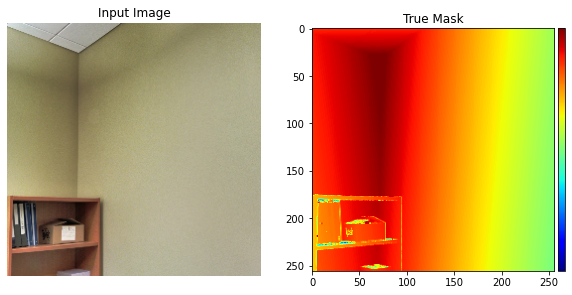

img Min and max pixel values: 0.0 189.5
img Min and max label values: 0.1 0.55049205


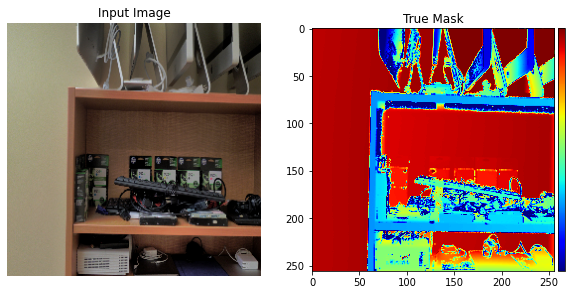

img Min and max pixel values: 0.0 255.0
img Min and max label values: 1.3137155 2.440857


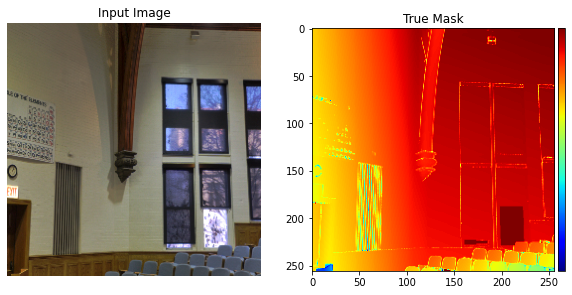

img Min and max pixel values: 5.0 128.0
img Min and max label values: 0.69766146 1.3437893


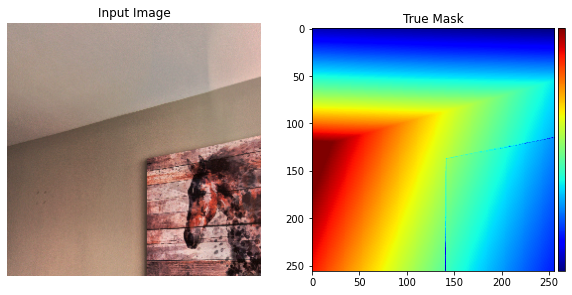

img Min and max pixel values: 0.0 255.0
img Min and max label values: 0.1 2.7687275


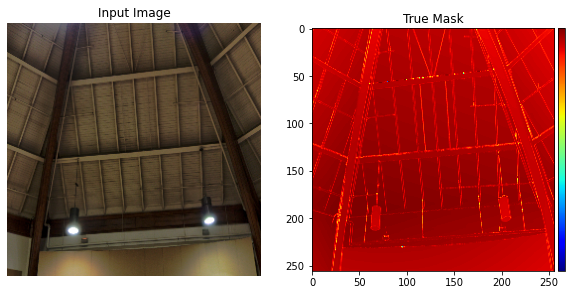

img Min and max pixel values: 6.0 255.0
img Min and max label values: 0.8310629 2.468577


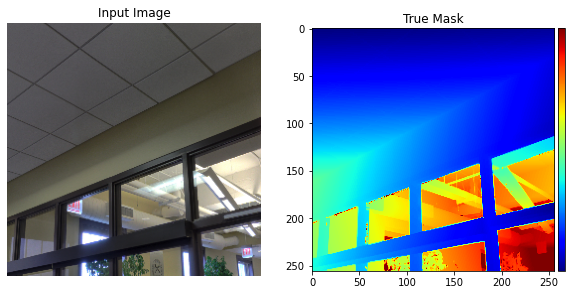

In [27]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def display_sample(display_list):
  """Show side-by-side an input image,
  the ground truth and the prediction.
  """
  fig = plt.figure(figsize=(10, 10))
  cmap = plt.cm.jet
  cmap.set_bad(color="black")

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    ax = plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    if i==0:
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    else:
      im = plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]),cmap=cmap)
      
      # create an axes on the right side of ax. The width of cax will be 5%
      # of ax and the padding between cax and ax will be fixed at 0.05 inch.
      divider = make_axes_locatable(ax)
      cax = divider.append_axes("right", size="3%", pad=0.05)
      if i==1:
        v = np.linspace(0.1, display_list[i].numpy().max(), 15, endpoint=True)
      else:
        v = np.linspace(0.1, display_list[i].max(), 15, endpoint=True)

      plt.colorbar(im, cax=cax, ticks=v)
      
    plt.axis('off')
  plt.show()

for image, mask in train_batches.take(6):
  sample_image, sample_mask = image, mask

  img, label = sample_image[0].numpy(), sample_mask[0].numpy() 
  print("img Min and max pixel values:", img.min(), img.max())
  print("img Min and max label values:", label.min(), label.max())
  
  display_sample([sample_image[0], sample_mask[0]])

## Building custom layers

In [122]:
from tensorflow.keras.layers import Layer, InputSpec
import keras.utils.conv_utils as conv_utils
import tensorflow as tf
import keras.backend as K
from tensorflow.keras.utils import get_custom_objects

In [123]:
def normalize_data_format(value):
  if value is None:
    value = K.image_data_format()
  data_format = value.lower()
  
  if data_format not in {'channels_first', 'channels_last'}:
    raise ValueError('The `data_format` argument must be one of '
                     '"channels_first", "channels_last". Received: ' +
                     str(value))
  return data_format
  
class BilinearUpSampling2D(layers.Layer):
  
  def __init__(self, size=(2, 2), data_format=None, **kwargs):
    super(BilinearUpSampling2D, self).__init__(**kwargs)
    self.data_format = normalize_data_format(data_format)
    self.size = conv_utils.normalize_tuple(size, 2, 'size')
    self.input_spec = InputSpec(ndim=4)

  def compute_output_shape(self, input_shape):
    
    if self.data_format == 'channels_first':
      height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
      width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
      return (input_shape[0],input_shape[1],height,width)
    
    elif self.data_format == 'channels_last':
      height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
      width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
      return (input_shape[0],height,width,input_shape[3])

  def call(self, inputs):
    input_shape = K.shape(inputs)
    if self.data_format == 'channels_first':
      height = self.size[0] * input_shape[2] if input_shape[2] is not None else None
      width = self.size[1] * input_shape[3] if input_shape[3] is not None else None
    elif self.data_format == 'channels_last':
      height = self.size[0] * input_shape[1] if input_shape[1] is not None else None
      width = self.size[1] * input_shape[2] if input_shape[2] is not None else None
        
    return tf.image.resize(inputs, [height, width], method=tf.image.ResizeMethod.BILINEAR)

  def get_config(self):
    config = {'size': self.size, 'data_format': self.data_format}
    base_config = super(BilinearUpSampling2D, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

In [124]:
class Conv2DT(tf.keras.Model):
  
  def __init__(self, act, kernel_size = 4, **kwargs):
    
    super().__init__(**kwargs)
    self.act = act
    self.kernel =(kernel_size,kernel_size)
    
  def build(self, input_shape):

    self.conv2dt = layers.Conv2DTranspose(input_shape[3], 
                                          self.kernel, 
                                          activation= self.act, 
                                          strides=(input_shape[1], input_shape[2]))

    super(Conv2DT, self).build(input_shape)
  
  @tf.function(jit_compile=True)
  def call(self, x):  
    return self.conv2dt(x)

In [125]:
class Dense_ASPP(tf.keras.Model):
  
  def __init__(self, filters, k = 1, kernel_size = 4, **kwargs):
    
    super().__init__(**kwargs)
    self.act     = layers.LeakyReLU(alpha=0.2)
    self.add     = layers.Add()
    self.batch   = layers.BatchNormalization()
    self.concat  = layers.Concatenate()
    self.conv2dt = Conv2DT(self.act,kernel_size)

    self.conv2d1 = layers.Conv2D(filters, 1, padding="same")
    self.conv2d2 = layers.Conv2D(filters, 1, dilation_rate=1*k, padding="same", use_bias=False)
    self.conv2d3 = layers.Conv2D(filters, 1, dilation_rate=6*k, padding="same", use_bias=False)
    self.conv2d4 = layers.Conv2D(filters, 1, dilation_rate=12*k, padding="same", use_bias=False)
    self.conv2d5 = layers.Conv2D(filters, 1, dilation_rate=18*k, padding="same", use_bias=False)
    self.conv2d6 = layers.Conv2D(filters, 1, dilation_rate=24*k, padding="same", use_bias=False)
    
    self.conv2d  = layers.Conv2D(filters, 1, dilation_rate=1, padding="same", use_bias=False)
    
  def build(self, input_shape):

    self.I1 = layers.AveragePooling2D(pool_size=(input_shape[1], input_shape[2]))
    self.I2 = layers.MaxPooling2D(pool_size=(input_shape[1], input_shape[2]))

    super(Dense_ASPP, self).build(input_shape)
  
  @tf.function(jit_compile=True)
  def call(self, x):
    
    I1 = self.I1(x)
    I2 = self.I2(x)
    y1 = self.add([I1, I2])

    y1 = self.conv2d1(y1)
    y1 = self.batch(y1)
    y1 = self.act(y1)
    y1 = self.conv2dt(y1)

    y2 = self.conv2d2(y1)
    y2 = self.concat([y1, y2])
    #y2 = self.batch(y2)
    #y2 = self.act(y2)

    y3 = self.conv2d3(y2)
    y3 = self.concat([y1, y2, y3])
    #y3 = self.batch(y3)
    #y3 = self.act(y3)

    y4 = self.conv2d4(y3)
    y4 = self.concat([y1, y2, y3, y4])
    #y4 = self.batch(y4)
    #y4 = self.act(y4)
    
    y5 = self.conv2d5(y4)
    y5 = self.concat([y1, y2, y3, y4, y5])
    #y5 = self.batch(y5)
    #y5 = self.act(y5)

    y6 = self.conv2d6(y5)
    y6 = self.concat([y1, y2, y3, y4, y5, y6])
    #y6 = self.batch(y6)
    #y6 = self.act(y6)
  
    y = self.conv2d(y6)
    y = self.batch(y)
    y = self.act(y)
      
    return y

## Building the DenseNet169 backbone

RetinaNet uses a DenseNet based backbone, using which a feature pyramid network
is constructed.

In [133]:
from tensorflow.keras.applications import DenseNet169
def get_backbone():

    """Builds DenseNet169 with pre-trained imagenet weights"""
    backbone = DenseNet169(
        input_shape=(HEIGHT, WIDTH, 3), 
        include_top=False, 
        weights='imagenet'
    )    
    
    
    c2_output, c3_output, c4_output, c5_output = [
        backbone.get_layer(layer_name).output
        for layer_name in ['conv1/relu', #128, 128, 64
                           'pool2_relu', #64, 64, 256
                           'pool3_relu', #32, 32, 512
                           'pool4_relu'  #16, 16, 1280
                           ]
    ]

    return tf.keras.Model(
        inputs=[backbone.inputs], 
        outputs=[c2_output, 
                 c3_output, 
                 c4_output, 
                 c5_output]
    )


## Building Feature Pyramid Network as a custom layer

* Our architecture is basically a Feature Pyramid 

* Network (FPN) with DenseNet169 as backbone.

* FPN is an effective backbone for monocular depth estimation because of its ability to extract features and semantics at different scales. It can achieve its potential if guided by proper loss functions.

* Two consecutive 3x3 convolutions for feature processing.

* ReLU is used as activation function in the last two convolutional layers. No non-linearity in the top-down branch of FPN.

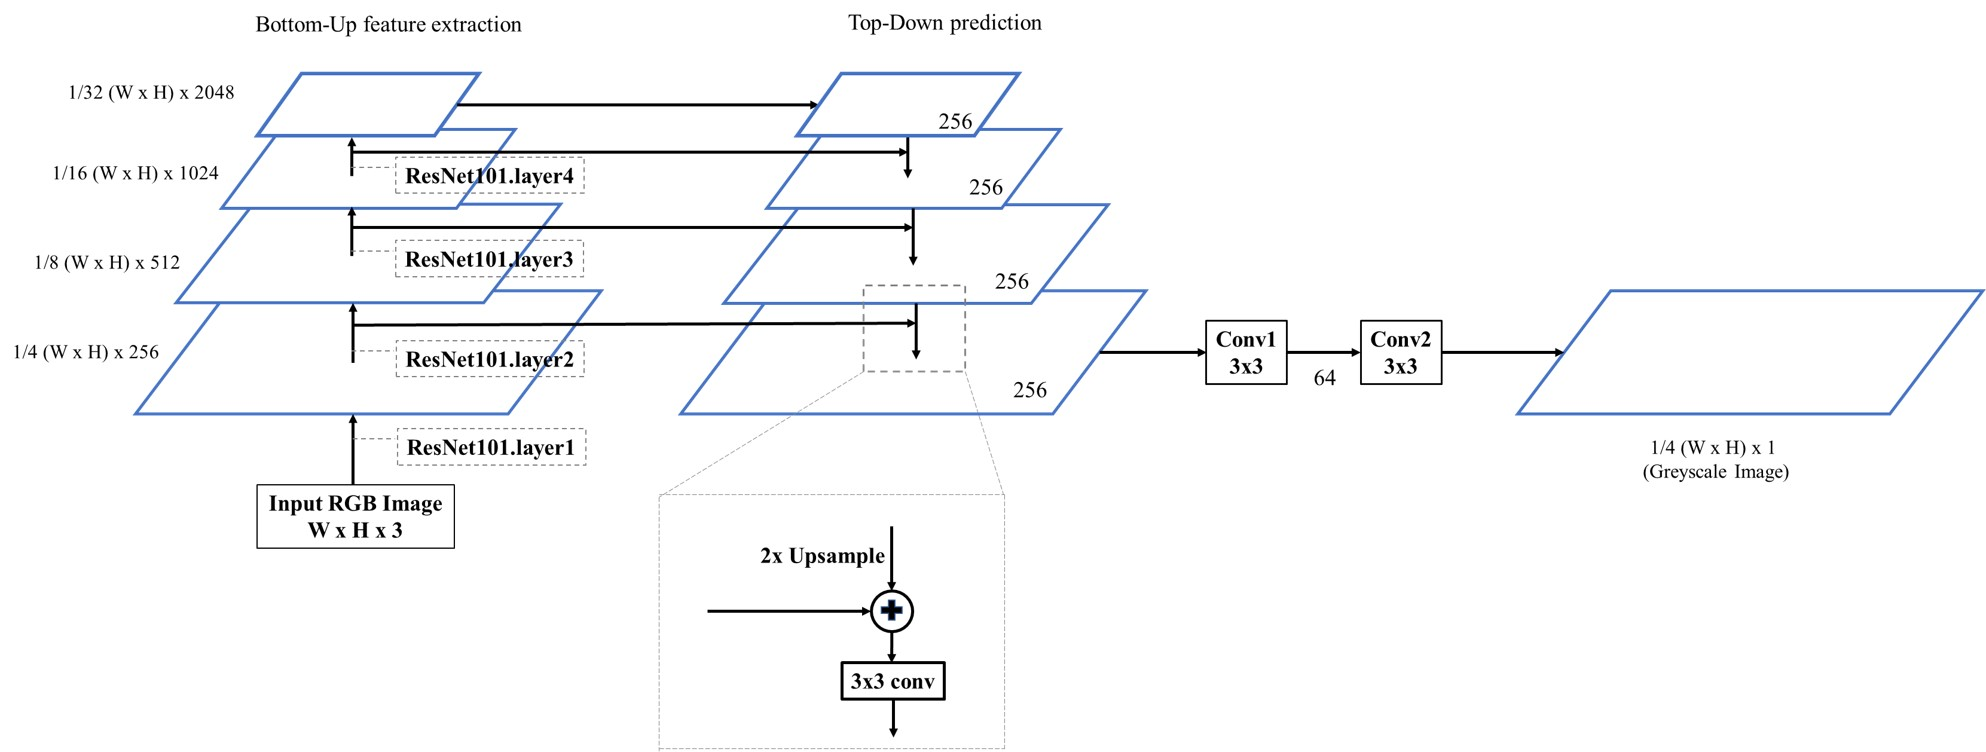

In [134]:

class I2D(layers.Layer):
    """Builds the Feature Pyramid with the feature maps from the backbone.

    Attributes:
      backbone: The backbone to build the feature pyramid from.
        Currently supports DenseNet169 only.
    """

    def __init__(self, backbone=None, **kwargs):
        super(I2D, self).__init__(name="I2D", **kwargs)
        self.backbone = backbone if backbone else get_backbone()
  
        # Top layer
        self.toplayer = layers.Conv2D(256, 1, 1, "valid") 
        # Lateral layers
        self.latlayer1 = layers.Conv2D(256, 1, 1, "valid") 
        self.latlayer2 = layers.Conv2D(256, 1, 1, "valid") 
        self.latlayer3 = layers.Conv2D(256, 1, 1, "valid") 
        # Smooth layers
        self.smooth1 = layers.Conv2D(256, 1, 1, "same") 
        self.smooth2 = layers.Conv2D(256, 1, 1, "same") 
        self.smooth3 = layers.Conv2D(256, 1, 1, "same") 
        # Depth prediction
        self.predict1 = layers.Conv2D(64, 1, 1, "same") 
        self.predict2 = layers.Conv2D(16, 1, 1, "same") 
        self.act = layers.LeakyReLU(alpha=0.2)
        # Up sampling
        self.upsample_2x = BilinearUpSampling2D((2,2))
        self.Dense_ASPP = Dense_ASPP(256, k =1, kernel_size= 16)
    
    #@tf.function(jit_compile=True)
    def call(self, images, training= False):

        c2_output, c3_output, c4_output, c5_output = self.backbone(images, training=training)
        c5_output = self.Dense_ASPP(c5_output)
        
        # Top-down 
        p5 = self.toplayer(c5_output)
        # 256 channels, 1/16 size
        p4 = self.upsample_2x(p5) + self.latlayer1(c4_output)      
        p4 = self.act(self.smooth1(p4))
        # 256 channels, 1/8 size
        p3 = self.upsample_2x(p4) + self.latlayer2(c3_output) 
        # 256 channels, 1/8 size
        p3 = self.act(self.smooth2(p3)) 
        # 256, 1/4 size
        p2 = self.upsample_2x(p3) + self.latlayer3(c2_output)
        # 256 channels, 1/4 size
        p2 = self.act(self.smooth3(p2)) 
        # depth; 1/4 size, mode = "L"
        return self.upsample_2x(self.act(self.predict2(self.act(self.predict1(p2)))))     


## Defining the loss

We will optimize 3 losses in our mode.
1. Structural similarity index(SSIM).
2. L1-loss, or Point-wise depth in our case.
3. Depth smoothness loss.

Out of the three loss functions, SSIM contributes the most to improving model performance.

In [135]:

class DepthEstimationModel(tf.keras.Model):

    def __init__(self, backbone=None):
        super().__init__()
        self.ssim_loss_weight = 0.85
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 0.6
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        
        self.I2D_layer = I2D(backbone)
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh")

    def calculate_loss(self, target, pred, maxDepthVal=WIDTH):
        
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        edges_loss = tf.reduce_mean(tf.abs(dx_true-dx_pred)) + tf.reduce_mean(tf.abs(dy_true-dy_pred))
        
        # Depth smoothness
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
            abs(smoothness_y)
        )

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean(
            1 
            - tf.image.ssim(
                target, pred, max_val= maxDepthVal, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
                )
        ) 
        ssim_loss = tf.clip_by_value(ssim_loss,0,1)

        # Multi-scale Structural similarity (SSIM)
        msssim_loss = tf.reduce_mean(
            1 
            - tf.image.ssim_multiscale(
                target, pred, max_val= maxDepthVal, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
                )
        ) 
        msssim_loss = tf.clip_by_value(msssim_loss,0,1)

        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))

        loss = (
              (self.l1_loss_weight * l1_loss)
            + (self.ssim_loss_weight * (ssim_loss )) #+ 1/4*msssim_loss
            + (self.edge_loss_weight * (depth_smoothness_loss + edges_loss))
        )

        return loss

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch_data):
        input, target = batch_data
        with tf.GradientTape() as tape:
            pred = self(input, training=True)
            loss = self.calculate_loss(target, pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def test_step(self, batch_data):
        input, target = batch_data

        pred = self(input, training=False)
        loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def call(self, x):
        #[64 256 256 16]
        return self.conv_layer(self.I2D_layer(x))


## Model training

In [136]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LR,
    amsgrad=False,
)
model = DepthEstimationModel()

# Define the loss function
cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)
# Compile the model
model.compile(optimizer, loss=cross_entropy)

model.fit(
    train_batches,
    epochs=EPOCHS,
    validation_data=val_batches,
    steps_per_epoch= (lengt_dataset-val_ds_size) // BATCH_SIZE,
    validation_steps= val_ds_size // BATCH_SIZE,
)

Epoch 1/200
16/16 [==============================] - 27s 545ms/step - loss: 0.3267 - val_loss: 0.3468
Epoch 2/200
16/16 [==============================] - 6s 320ms/step - loss: 0.2481 - val_loss: 0.3502
Epoch 3/200
16/16 [==============================] - 5s 308ms/step - loss: 0.2512 - val_loss: 0.3471
Epoch 4/200
16/16 [==============================] - 5s 309ms/step - loss: 0.2365 - val_loss: 0.3532
Epoch 5/200
16/16 [==============================] - 5s 309ms/step - loss: 0.2453 - val_loss: 0.3466
Epoch 6/200
16/16 [==============================] - 5s 309ms/step - loss: 0.2313 - val_loss: 0.3480
Epoch 7/200
16/16 [==============================] - 5s 309ms/step - loss: 0.2198 - val_loss: 0.3388
Epoch 8/200
16/16 [==============================] - 5s 308ms/step - loss: 0.2148 - val_loss: 0.3573
Epoch 9/200
16/16 [==============================] - 5s 309ms/step - loss: 0.2040 - val_loss: 0.3208
Epoch 10/200
16/16 [==============================] - 5s 308ms/step - loss: 0.2013 - val_l

## Visualizing model output

We visualize the model output over the validation set.
The first image is the RGB image, the second image is the ground truth depth map image
and the third one is the predicted depth map image.

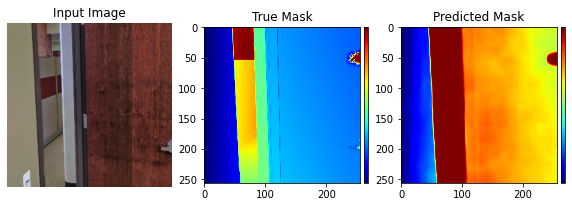

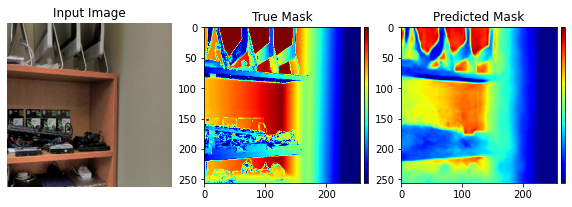

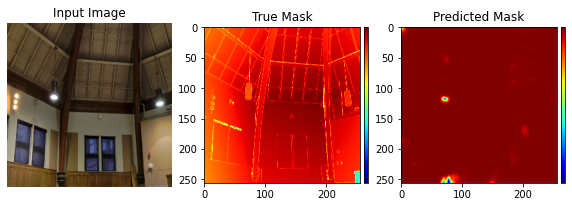

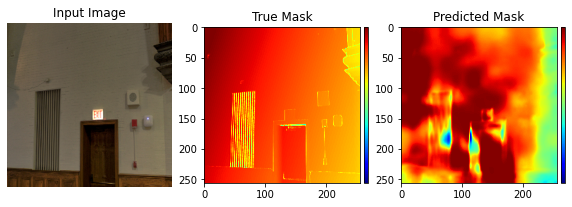

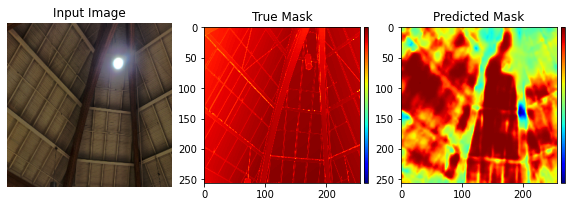

In [137]:
for image, mask in val_batches.take(6):
  sample_image, sample_mask = image, mask
  pred = model.predict(sample_image)

  img, label = sample_image[0].numpy(), sample_mask[0].numpy() 
  #print("img Min and max pixel values:", img.min(), img.max())
  #print("img Min and max label values:", label.min(), label.max())
  
  display_sample([sample_image[0], sample_mask[0], pred[0]])

## Possible improvements

1. You can improve this model by replacing the encoding part of the U-Net with a
pretrained DenseNet or ResNet.
2. Loss functions play an important role in solving this problem.
Tuning the loss functions may yield significant improvement.

## References

The following papers go deeper into possible approaches for depth estimation.
1. [Depth Prediction Without the Sensors: Leveraging Structure for Unsupervised Learning from Monocular Videos](https://arxiv.org/pdf/1811.06152v1.pdf)
2. [Digging Into Self-Supervised Monocular Depth Estimation](https://openaccess.thecvf.com/content_ICCV_2019/papers/Godard_Digging_Into_Self-Supervised_Monocular_Depth_Estimation_ICCV_2019_paper.pdf)
3. [Deeper Depth Prediction with Fully Convolutional Residual Networks](https://arxiv.org/pdf/1606.00373v2.pdf)

You can also find helpful implementations in the papers with code depth estimation task.